# 線形回帰 Linear Regression による要因探索とメトリック記録

糖尿病の被験者データに線形回帰を適用し、説明変数・因子がどのように糖尿病の進行に影響しているかを分析します。Scikit Learnを使用し線形回帰で学習します。Azure Machine Learning service のメトリック記録機能を使って、作業内容を記録することも示します。

## Azure Machine Learning service
Azure Machine Learning service の資産管理の仕組みを利用して、メトリック、データセット、モデルを保存します。
### Python SDK インポート

In [1]:
import azureml.core
from azureml.core.experiment import Experiment
from azureml.core.workspace import Workspace

In [2]:
print("Azure ML SDK Version: ", azureml.core.VERSION)

Azure ML SDK Version:  1.0.62


### ワークスペースへの接続

In [3]:
ws = Workspace.from_config()
print(ws.name, ws.location, ws.resource_group, ws.location, sep = '\t')

azureml	eastus	mlservice	eastus


### 実験の開始

In [4]:
experiment=Experiment(ws, "linear-regression-explore")
# 実験メトリックの記録開始
run = experiment.start_logging()

# 学習データの準備

In [5]:
import pandas as pd
from sklearn import datasets
from sklearn.model_selection import train_test_split

# sklearn の糖尿病のサンプルデータをロード
diabetes = datasets.load_diabetes()
X = pd.DataFrame(diabetes.data, columns=("age", "sex", "bmi", "map", "tc", "ldl", "hdl", "tch", "ltg", "glu"))
y = pd.DataFrame(diabetes.target, columns=["y"])

In [6]:
X.head()

,age,sex,bmi,map,tc,ldl,hdl,tch,ltg,glu
0,0.038076,0.050680,0.061696,0.021872,-0.044223,-0.034821,-0.043401,-0.002592,0.019908,-0.017646
1,-0.001882,-0.044642,-0.051474,-0.026328,-0.008449,-0.019163,0.074412,-0.039493,-0.068330,-0.092204
2,0.085299,0.050680,0.044451,-0.005671,-0.045599,-0.034194,-0.032356,-0.002592,0.002864,-0.025930
3,-0.089063,-0.044642,-0.011595,-0.036656,0.012191,0.024991,-0.036038,0.034309,0.022692,-0.009362
4,0.005383,-0.044642,-0.036385,0.021872,0.003935,0.015596,0.008142,-0.002592,-0.031991,-0.046641


In [7]:
y.head()

,y
0,151.0
1,75.0
2,141.0
3,206.0
4,135.0


In [8]:
# 学習データとテストデータに分割
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.1,random_state=100)

# 線形回帰 Linear Regression による学習
[Linear Regression](https://scikit-learn.org/0.20/modules/generated/sklearn.linear_model.LinearRegression.html#sklearn.linear_model.LinearRegression) による機械学習モデリング

In [9]:
from sklearn import linear_model

lr = linear_model.LinearRegression()
lr = lr.fit(X_train, y_train)

/Users/konabuta/miniconda3/envs/myenv/lib/python3.6/site-packages/sklearn/linear_model/base.py:485: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  linalg.lstsq(X, y)


### モデル精度の確認

In [10]:
from sklearn.metrics import mean_absolute_error,mean_squared_error

pred = lr.predict(X_test)
mae = mean_absolute_error(y_test, pred)
mse = mean_squared_error(y_test,pred)
print("平均絶対誤差", mae)
print("平均二乗誤差", mse)

平均絶対誤差 39.90285306407927
平均二乗誤差 2525.7799143633047


## モデルの解釈

In [11]:
# 回帰係数と切片の大きさ
print(lr.coef_, lr.intercept_)

[[ -47.976923   -224.02487968  527.14980328  327.11373838 -688.61659641
   425.04508039   96.98090996  162.53776611  736.83537797   55.59044149]] [151.48940506]


In [12]:
coeff_df = pd.DataFrame(lr.coef_[0], ("age", "sex", "bmi", "map", "tc", "ldl", "hdl", "tch", "ltg", "glu"), columns=["Feature Importance"]).abs()
coeff_df.sort_values(by=["Feature Importance"], ascending=False)

,Feature Importance
ltg,736.835378
tc,688.616596
bmi,527.149803
ldl,425.045080
map,327.113738
sex,224.024880
tch,162.537766
hdl,96.980910
glu,55.590441
age,47.976923


<Figure size 432x288 with 0 Axes>

<Figure size 432x432 with 0 Axes>

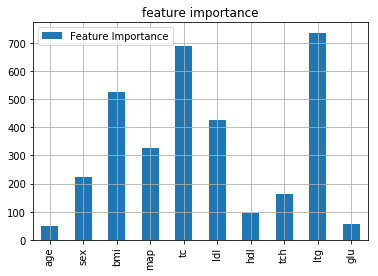

In [13]:
%matplotlib inline

import matplotlib.pyplot as plt

plt.clf()
plt.figure(figsize=(6,6))
coeff_df.plot.bar()
plt.title("feature importance")
plt.legend()
plt.grid(True)
plt.savefig('lr-im.png')
plt.show()

## メトリックの記録

Experiment に紐づけて、利用したハイパーパラメータやモデル精度を記録します。

In [14]:
# 精度
run.log("平均絶対誤差", mae)
run.log("平均二乗誤差", mse)

# 画像記録
run.log_image("feature importance", "lr-im.png")

### モデル登録

In [15]:
import pickle
filename = 'lr-model.pkl'
pickle.dump(lr, open(filename, 'wb'))

In [16]:
run.upload_file("outputs/"+filename, filename)

# モデル登録

Azure Machine Learning service 上にモデルを保存します。

In [17]:
from azureml.core.model import Model

model = run.register_model(model_name='lr-sklearn', 
                           model_path = 'outputs/' + filename,
                           tags = {'area': "sklearn による線形回帰", 'type': "回帰 Regression", 'run_id' : run.id}
                          )

In [18]:
print(model.name, model.version, model.tags)

lr-sklearn 8 {'area': 'sklearn による線形回帰', 'type': '回帰 Regression', 'run_id': '9ce173bf-0d7d-4edd-8635-d5babfbf394a'}


## 実験完了

start_logging() で始めた Experiment を終了します。

In [19]:
run.complete()

In [20]:
# Git情報などの確認
run.get_details()

{'runId': '9ce173bf-0d7d-4edd-8635-d5babfbf394a',
 'target': 'sdk',
 'status': 'Completed',
 'startTimeUtc': '2019-09-22T05:21:39.674366Z',
 'endTimeUtc': '2019-09-22T05:22:00.314263Z',
 'properties': {'azureml.git.repository_uri': 'https://github.com/konabuta/DataExplore-Workshop.git',
  'mlflow.source.git.repoURL': 'https://github.com/konabuta/DataExplore-Workshop.git',
  'azureml.git.branch': 'master',
  'mlflow.source.git.branch': 'master',
  'azureml.git.commit': '279341ec30a72695aeb9220af510d5a30520bbd6',
  'mlflow.source.git.commit': '279341ec30a72695aeb9220af510d5a30520bbd6',
  'azureml.git.dirty': 'True',
  'ContentSnapshotId': '715bd63d-e3dd-4c37-9452-f3a1af548647'},
 'logFiles': {}}

In [21]:
run

Experiment,Id,Type,Status,Details Page,Docs Page
linear-regression-explore,9ce173bf-0d7d-4edd-8635-d5babfbf394a,,Completed,Link to Azure Portal,Link to Documentation
